# 1. Import packages

In [309]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import matplotlib.pyplot as plt

In [310]:
VERSION = "v0.1"
VERSION = "v0.2"

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(3)

# 2. Load data

In [ ]:
train_df = pd.read_csv(f"../DATA/training/btc_data/{VERSION}/train.csv")
val_df = pd.read_csv(f"../DATA/training/btc_data/{VERSION}/val.csv")

features = ['Open', 'High', 'Low', 'Volume']
target = 'Price'

# 3. Preprocess data

## 3.1 Clean data

In [312]:
def clean_data(df: pd.DataFrame):
    df = df.drop(columns=['Change %'])
    df.rename(columns={'Vol.': 'Volume'}, inplace=True)

    df.sort_values('Date', inplace=True)
    df['Volume'] = (
        df['Volume']
        .str.replace('K', 'e3')
        .str.replace('M', 'e6')
        .str.replace('B', 'e9')
        .astype(float)
    )
    columns_to_clean = ['Price', 'Open', 'High', 'Low']
    for col in columns_to_clean:
        df[col] = df[col].str.replace(',', '').astype(float)

    df = df.drop(columns=['Date'])
    return df

In [313]:
train_df = clean_data(train_df)
val_df = clean_data(val_df)

## 3.2 Scale data

In [314]:
features_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

In [315]:
train_df[features] = features_scaler.fit_transform(train_df[features])
train_df[target] = target_scaler.fit_transform(train_df[[target]])

val_df[features] = features_scaler.transform(val_df[features])
val_df[target] = target_scaler.transform(val_df[[target]])

## 3.3 Create training data

In [316]:
def create_sequences(data: pd.DataFrame, 
                     lookback: int=7
                     )-> tuple:
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data.iloc[i-lookback:i].values)
        y.append(data[target][i])
    return np.array(X), np.array(y)

In [317]:
LOOKBACK = 14

X_train, y_train = create_sequences(train_df, LOOKBACK)
X_val, y_val = create_sequences(val_df, LOOKBACK)

## 3.4 Create data loader

In [318]:
class BTCData(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [319]:
BATCH_SIZE = 16

train_data = BTCData(X_train, y_train)
val_data = BTCData(X_val, y_val)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

# 4. Modeling

In [320]:
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        out, _ = self.rnn(x)
        x = self.fc1(out[:, -1, :])
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [321]:
input_size = len(features) + 1
hidden_size = 128
num_layers = 2

model = RNN_Model(input_size=input_size,
                  hidden_size=hidden_size, 
                  output_size=1, 
                  num_layers=num_layers)

# 5. Training

In [322]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [323]:
def evaluate(model, loader):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for X, y in loader:
            y_pred = model(X)
            loss = criterion(y_pred.view(-1), y)
            running_loss += loss.item()
    return running_loss / len(loader)

In [324]:
hist = {
    'train_loss': [],
    'val_loss': []
}

EPOCHS = 10

best_model = None
best_loss = np.inf
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    for i, (X_batch, y_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.view(-1), y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    val_loss = evaluate(model, val_loader)
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model.state_dict()

    hist['train_loss'].append(epoch_loss)
    hist['val_loss'].append(val_loss)
    print(f"Epoch {epoch + 1}, train loss: {epoch_loss:.6f}, val loss: {val_loss:.6f}")


model.load_state_dict(best_model)

Epoch 1, train loss: 0.005840, val loss: 0.000136
Epoch 2, train loss: 0.000341, val loss: 0.000666
Epoch 3, train loss: 0.000371, val loss: 0.001125
Epoch 4, train loss: 0.000362, val loss: 0.000220
Epoch 5, train loss: 0.000325, val loss: 0.000680
Epoch 6, train loss: 0.000318, val loss: 0.000322
Epoch 7, train loss: 0.000413, val loss: 0.000122
Epoch 8, train loss: 0.000364, val loss: 0.000296
Epoch 9, train loss: 0.000363, val loss: 0.000144
Epoch 10, train loss: 0.000290, val loss: 0.000474


<All keys matched successfully>

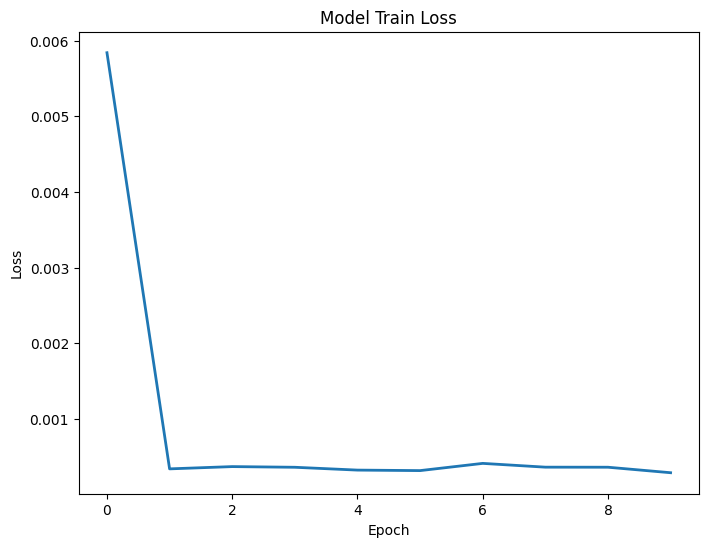

In [325]:
plt.figure(figsize=(8, 6))
plt.plot(hist['train_loss'], label='Train', linewidth=2)
plt.title('Model Train Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

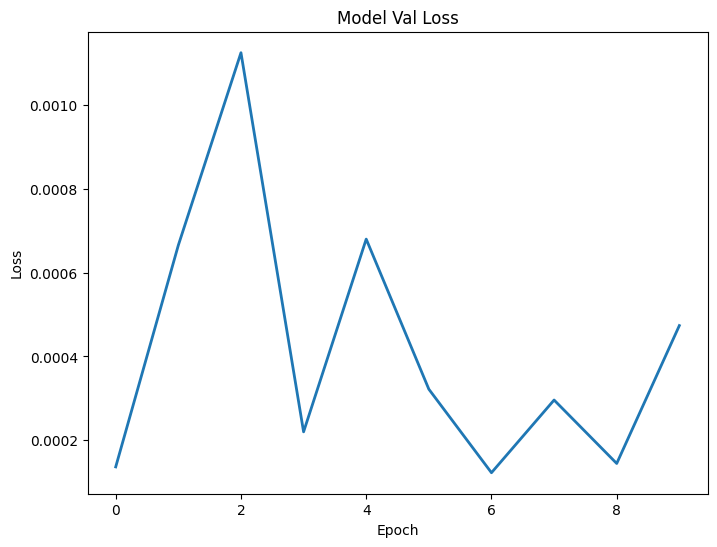

In [326]:
plt.figure(figsize=(8, 6))
plt.plot(hist['val_loss'], label='Train', linewidth=2)
plt.title('Model Val Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

# 6. Testing

In [ ]:
test_df = pd.read_csv(f"../DATA/training/btc_data/{VERSION}/test.csv")
test_df = clean_data(test_df)

test_df[features] = features_scaler.transform(test_df[features])
test_df[target] = target_scaler.transform(test_df[[target]])

X_test, y_test = create_sequences(test_df, LOOKBACK)
test_data = BTCData(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

test_loss = evaluate(model, test_loader)
print(f"Test loss: {test_loss:.6f}")

Test loss: 0.000723


# 7. Prediction

In [328]:
def predict_futures(model, input_data: pd.DataFrame, features_scaler, target_scaler, next_days=1):
    input_data.loc[:, features] = features_scaler.transform(input_data[features])
    input_data.loc[:, target] = target_scaler.transform(input_data[[target]])
    X_input = torch.tensor(input_data.values, dtype=torch.float32).unsqueeze(0)

    model.eval()
    predictions = []
    for _ in range(next_days):
        with torch.no_grad():
            y_pred = model(X_input)
        y_prediction = y_pred.item()
        predictions.append(y_prediction)
        
        last_row = input_data.iloc[-1].values.tolist()
        next_input = [y_prediction] + last_row[:-1]
        next_input = torch.tensor([next_input], dtype=torch.float32).unsqueeze(1)
        X_input = torch.cat([X_input[:, 1:, :], next_input], dim=1)
    
    unscaled_predictions = target_scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
    return unscaled_predictions


In [ ]:
test_df = pd.read_csv(f"../DATA/training/btc_data/v0.2/test.csv")
test_df = clean_data(test_df)

start_date = 0
look_date = 14
next_days = 7

predict_df = test_df[start_date:start_date+look_date]

In [330]:
futures = predict_futures(model, predict_df, features_scaler, target_scaler, next_days=next_days)
futures

array([[51971.6341091 ],
       [52377.7547886 ],
       [52931.2652342 ],
       [52307.44643583],
       [51662.8303574 ],
       [51944.65342315],
       [52078.91142007]])

In [331]:
gt_values = test_df[target].values[start_date+look_date: start_date+look_date+next_days]
gt_values

array([51901.3, 52134.2, 51646. , 52117.5, 51783.6, 52263.5, 51858.2])

In [332]:
raise Exception("STOP")

Exception: STOP

# 8. Test on new data

In [ ]:
test_df = pd.read_csv("../DATA/training/btc_data/v0.2/test.csv")
test_df = clean_data(test_df)

test_df[features] = features_scaler.transform(test_df[features])
test_df[target] = target_scaler.transform(test_df[[target]])

X_test, y_test = create_sequences(test_df, LOOKBACK)
test_data = BTCData(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

test_loss = evaluate(model, test_loader)
print(f"Test loss: {test_loss:.6f}") # 0.001031 vs  0.000909

Test loss: 0.002529
